<a href="https://colab.research.google.com/github/leighTOR/fishlens-efficientnet/blob/main/fishlens_efficientnetv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install efficientnet_pytorch
!pip install torch torchvision
!pip install efficientnet_pytorch
!pip install roboflow

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=2a9e788c29ab3b5aece7dba845aec249d524ce5b15307962bd960c744046d518
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8


In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from roboflow import Roboflow

In [3]:
# Roboflow dataset loading
rf = Roboflow(api_key="W65oY4Om8xYEo0mK9UED")
project = rf.workspace("fishlens").project("fishlens-modelv1")
version = project.version(2)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fishlens-modelv1-2 in yolov5pytorch:: 100%|██████████| 15012/15012 [00:02<00:00, 5516.46it/s]


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 39.7MB/s]


Loaded pretrained weights for efficientnet-b0
Epoch 1/5 started.
[1/5]
Train Loss: 0.8564 | Train Acc: 72.11%
Val Loss: 0.8762 | Val Acc: 77.75%
Precision: 0.80 | Recall: 0.78 | F1: 0.76

Epoch 2/5 started.
[2/5]
Train Loss: 0.4132 | Train Acc: 86.91%
Val Loss: 0.7302 | Val Acc: 80.72%
Precision: 0.80 | Recall: 0.81 | F1: 0.80

Epoch 3/5 started.
[3/5]
Train Loss: 0.2846 | Train Acc: 90.20%
Val Loss: 0.8371 | Val Acc: 81.78%
Precision: 0.80 | Recall: 0.81 | F1: 0.80

Epoch 4/5 started.
[4/5]
Train Loss: 0.2500 | Train Acc: 91.90%
Val Loss: 0.8177 | Val Acc: 82.84%
Precision: 0.84 | Recall: 0.85 | F1: 0.83

Epoch 5/5 started.
[5/5]
Train Loss: 0.1846 | Train Acc: 93.68%
Val Loss: 0.8104 | Val Acc: 82.20%
Precision: 0.81 | Recall: 0.82 | F1: 0.81



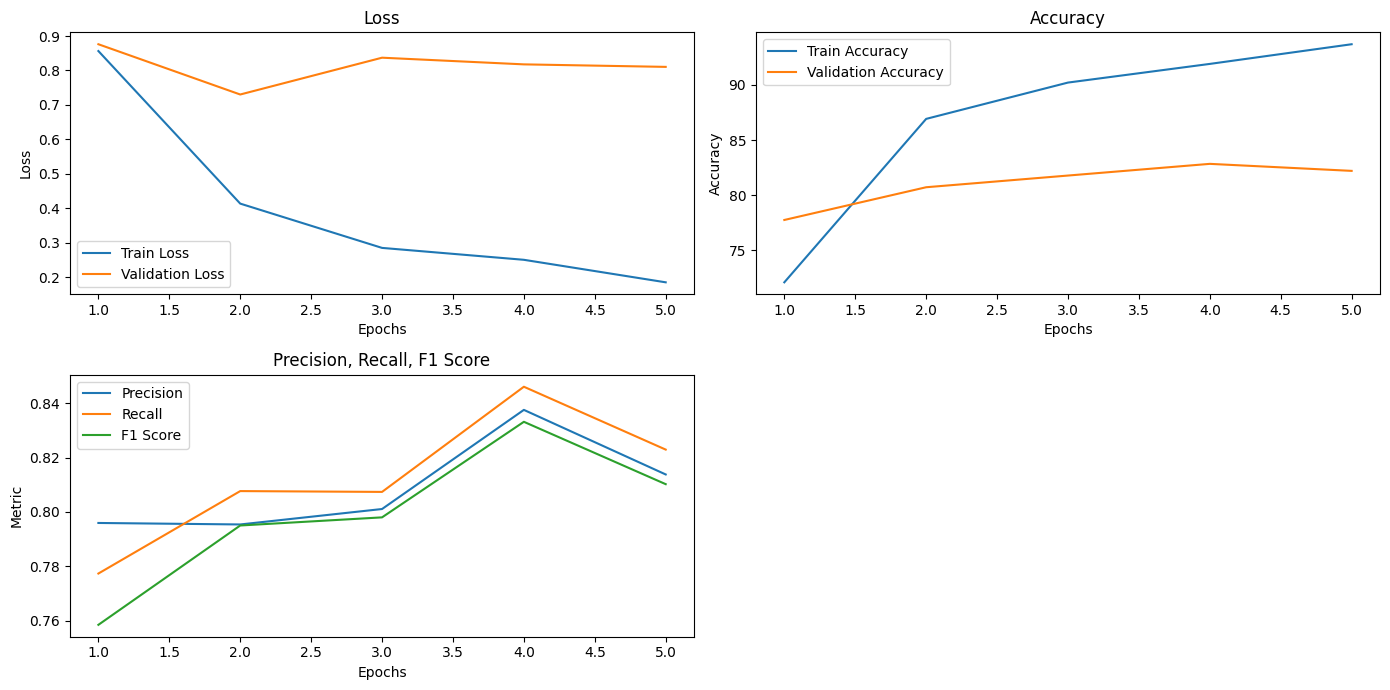

In [4]:
# Create a directory to save results if it doesn't exist
results_folder = 'results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Define the dataset class
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.image_files[idx].replace(".jpg", ".txt"))

        image = Image.open(image_path).convert("RGB")

        with open(label_path, 'r') as f:
            label_data = f.readlines()

        labels = []
        for label in label_data:
            parts = label.strip().split()
            class_label = int(parts[0])
            bbox = list(map(float, parts[1:5]))
            labels.append([class_label] + bbox)

        labels = torch.tensor(labels)

        if self.transform:
            image = self.transform(image)

        return image, labels

    def collate_fn(self, batch):
        images, labels = zip(*batch)
        max_len = max(len(l) for l in labels)
        padded_labels = [torch.cat([l, torch.zeros(max_len - len(l), 5)], dim=0) for l in labels]
        return torch.stack(images), torch.stack(padded_labels)

# Define image transformations
img_size = 224
batch_size = 32

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Setup directories
train_image_dir = '/content/fishlens-modelv1-2/train/images'
train_label_dir = '/content/fishlens-modelv1-2/train/labels'
val_image_dir = '/content/fishlens-modelv1-2/valid/images'
val_label_dir = '/content/fishlens-modelv1-2/valid/labels'

# Create datasets and dataloaders
train_dataset = YoloDataset(train_image_dir, train_label_dir, transform=train_transforms)
val_dataset = YoloDataset(val_image_dir, val_label_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)

# Load and modify EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0')
num_classes = 11
model._fc = nn.Linear(model._fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        class_labels = labels[:, 0, 0].long().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, class_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += class_labels.size(0)
        correct += predicted.eq(class_labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(class_labels.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(train_loader), accuracy, all_preds, all_labels

def validate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, targets = inputs.to(device), labels[:, 0, 0].long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(val_loader), accuracy, all_preds, all_labels

# Function to calculate precision, recall, and F1-score
def calculate_metrics(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    return precision, recall, f1

# Plotting function with saving functionality
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, precisions, recalls, f1s, save_dir):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 7))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')
    plt.savefig(f'{save_dir}/loss_curve.png')

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.savefig(f'{save_dir}/accuracy_curve.png')

    # Plot Precision, Recall, F1-Score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, precisions, label='Precision')
    plt.plot(epochs, recalls, label='Recall')
    plt.plot(epochs, f1s, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.title('Precision, Recall, F1 Score')
    plt.savefig(f'{save_dir}/precision_recall_f1.png')

    plt.tight_layout()
    plt.show()

# Initialize lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
precisions, recalls, f1s = [], [], []

epochs = 5
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs} started.')

    # Train
    train_loss, train_acc, train_preds, train_labels = train(model, device, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validate
    val_loss, val_acc, val_preds, val_labels = validate(model, device, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Calculate Precision, Recall, F1-Score
    precision, recall, f1 = calculate_metrics(val_labels, val_preds)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # Updated print formatting
    print(f'[{epoch+1}/{epochs}]')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}\n')

# Plot all metrics and save graphs
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, precisions, recalls, f1s, results_folder)

# Save model checkpoint
torch.save(model.state_dict(), f'{results_folder}/model_checkpoint.pth')
